# Text Analysis Notebook

This notebook performs a comprehensive text analysis on a government program PDF. The analysis includes PDF processing, token statistics, part-of-speech and named entity analyses, word cloud generation, keyword extraction, entity network visualization, document structure analysis, and more.

In [1]:
# Import necessary libraries
import re
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdfplumber as pp
from collections import Counter

from wordcloud import WordCloud

# Set visualization style
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (14, 8)

## 0. Setup 

### Get data




In [2]:
# import requests
# url = 'https://b.ds.at/lido-files/2025/02/27/3dfd41d6-f95a-44f3-90b0-c6b15eff07de.pdf'

# r = requests.get(url, stream=True) # stream=True allows downloading large files in pieces
# chunk_size = 2000 # size of each chunk in bytes

# with open('../data/02_pdf-analysis/Regierungsprogramm_2025.pdf', 'wb+') as fd: # wb = write binary
#     for chunk in r.iter_content(chunk_size):
#         fd.write(chunk)


# alternatively, if file is small enough, you can use the following code to download the file
# with open('regierungsprogram.pdf', 'wb') as f:
#     f.write(r.content)

## Install pdfplumber

In [3]:
%pip install pdfplumber

Note: you may need to restart the kernel to use updated packages.


### Install language corpus

In [4]:
# Check if model is already installed
if "de_core_news_lg" not in spacy.util.get_installed_models():
    print("Installing de_core_news_lg model...")
    !python -m spacy download de_core_news_lg
else:
    print("de_core_news_lg already installed!")

de_core_news_lg already installed!


## 1.2 Read data

In [5]:
# Load the German language model
print("Loading German language model...")
german_lang = spacy.load("de_core_news_lg")
german_lang.add_pipe("sentencizer")

Loading German language model...


In [6]:
pdf_path = "data/02_pdf-analysis/Regierungsprogramm_2025.pdf"

with pp.open(pdf_path) as pdf:
    text = "\n".join([page.extract_text() for page in pdf.pages if page.extract_text()])

text = re.sub(r"\n+", " ", re.sub(r"\s+", " ", text))
doc = german_lang(text)

## 1.2 Word Cloud


Generating word cloud...


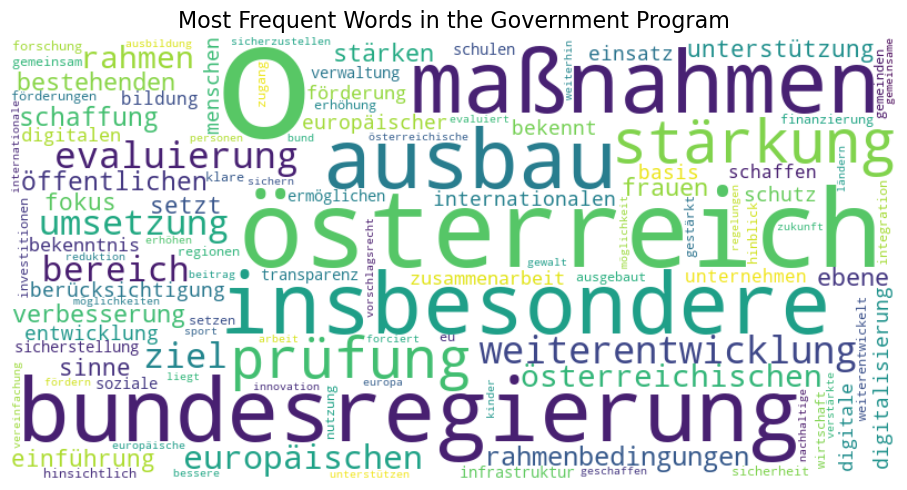

In [7]:
print("\nGenerating word cloud...")


def generate_wordcloud(text, title="Word Cloud", stopwords=None):
    # Filter out stopwords and punctuation
    if stopwords is None:
        stopwords = []

    # Create and generate a word cloud image
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=stopwords,
        min_font_size=10,
        max_font_size=150,
        collocations=False,
        random_state=42,
    ).generate(text)

    # Display the generated image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# Create a list of tokens excluding stopwords and punctuation
filtered_tokens = [
    token.text.lower()
    for token in doc
    if not token.is_stop and not token.is_punct and token.is_alpha
]
filtered_text = " ".join(filtered_tokens)

# Generate word cloud
generate_wordcloud(filtered_text, title="Most Frequent Words in the Government Program")

## 1.3 Most Common Words


Analyzing most common nouns...


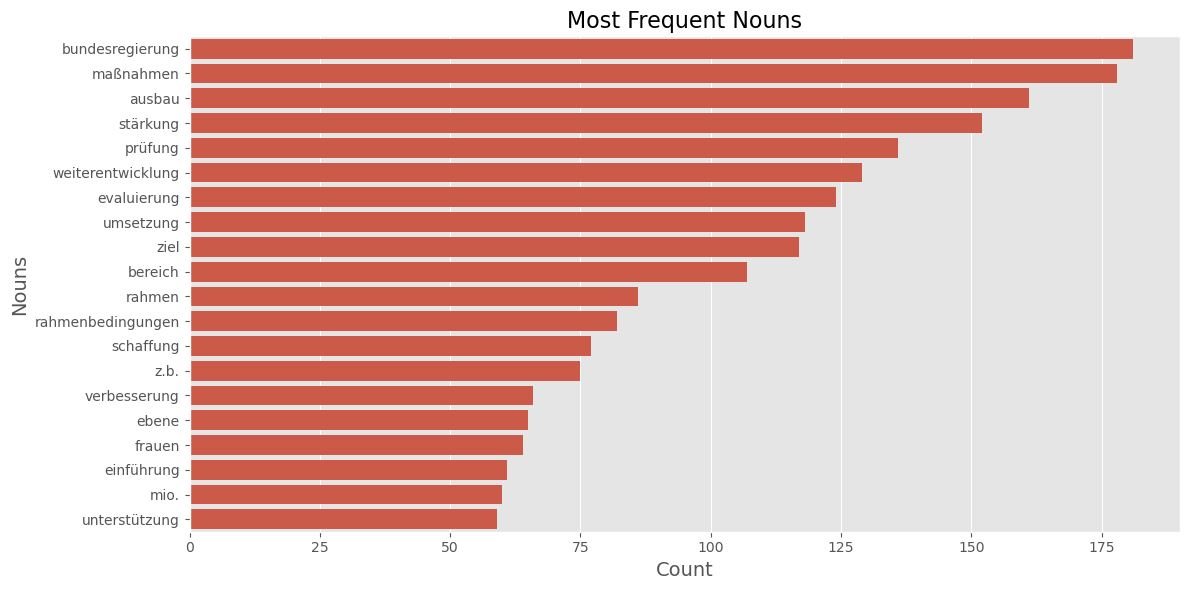

In [8]:
print("\nAnalyzing most common nouns...")
nouns = [
    token.text.lower() for token in doc if token.pos_ == "NOUN" and not token.is_stop
]
noun_counts = Counter(nouns).most_common(20)
noun_df = pd.DataFrame(noun_counts, columns=["Noun", "Count"])

plt.figure(figsize=(12, 6))
sns.barplot(x="Count", y="Noun", data=noun_df)
plt.title("Most Frequent Nouns", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Nouns", fontsize=14)
plt.tight_layout()
plt.show()


Analyzing most common adjectives...


/var/folders/rz/q6x0q6d95wgbtn0lvy7_wcb00000gq/T/ipykernel_41199/1857998250.py:13: UserWarning: Glyph 61607 (\uf0a7) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/djpyworkshop/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 61607 (\uf0a7) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


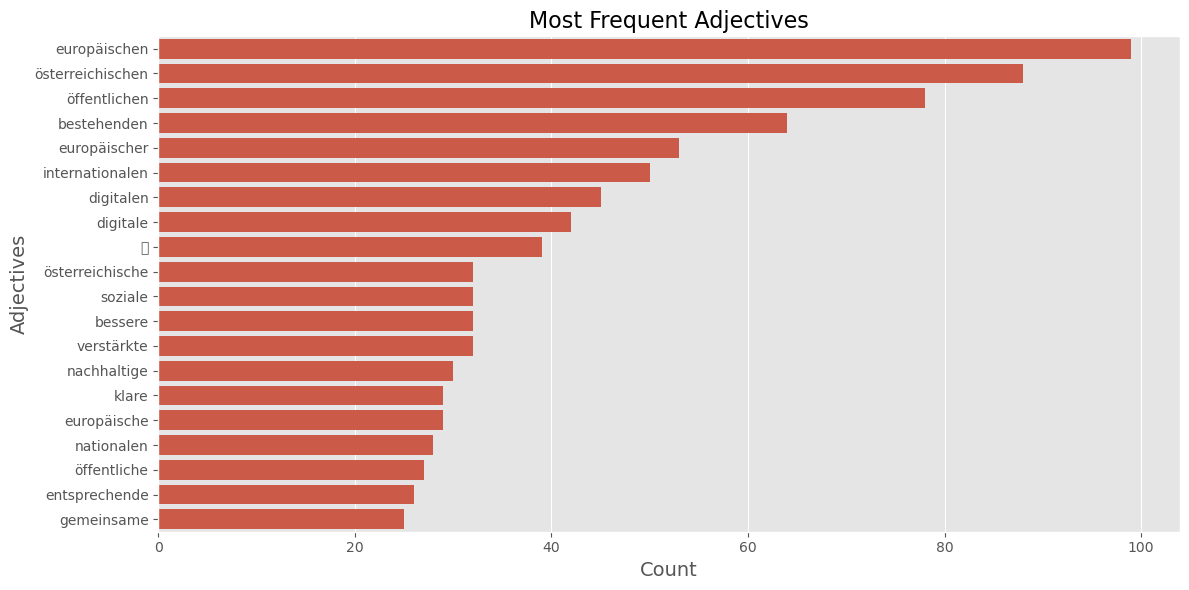

In [9]:
print("\nAnalyzing most common adjectives...")
adjectives = [
    token.text.lower() for token in doc if token.pos_ == "ADJ" and not token.is_stop
]
adj_counts = Counter(adjectives).most_common(20)
adj_df = pd.DataFrame(adj_counts, columns=["Adjective", "Count"])

plt.figure(figsize=(12, 6))
sns.barplot(x="Count", y="Adjective", data=adj_df)
plt.title("Most Frequent Adjectives", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Adjectives", fontsize=14)
plt.tight_layout()
plt.show()

### 1.4 Sentence Length Analysis

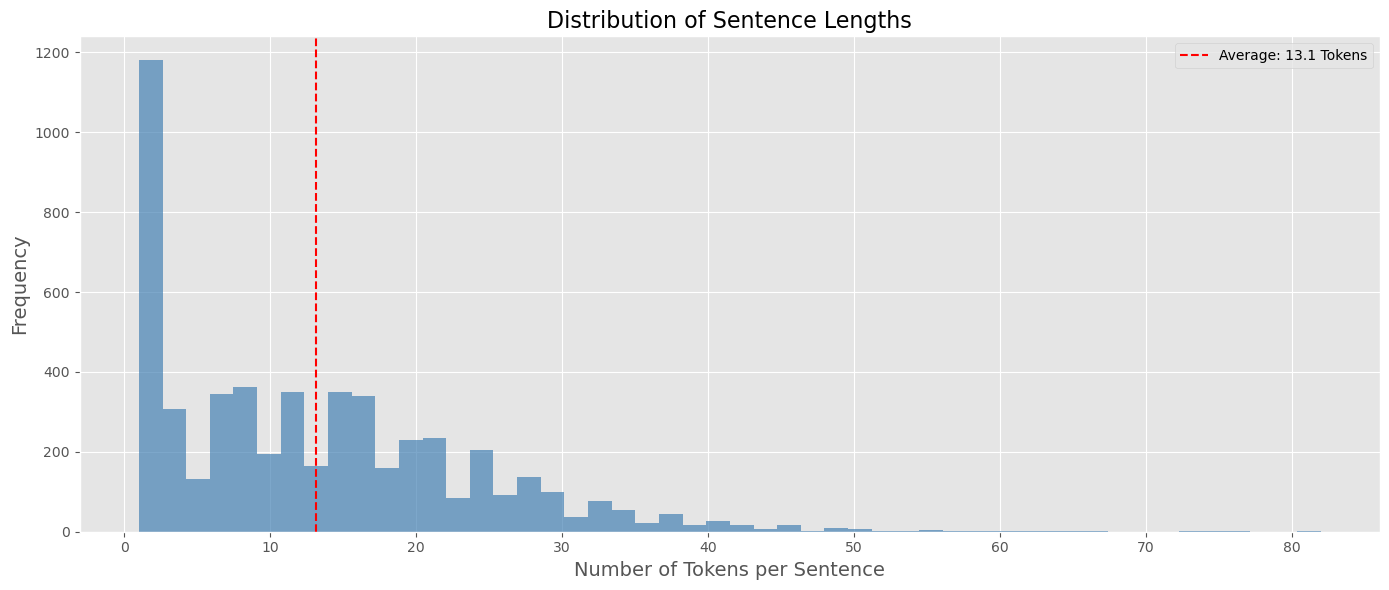

In [10]:
sentence_lengths = [len(sent) for sent in doc.sents]

plt.figure(figsize=(14, 6))
plt.hist(sentence_lengths, bins=50, alpha=0.7, color="steelblue")
plt.axvline(
    x=np.mean(sentence_lengths),
    color="red",
    linestyle="--",
    label=f"Average: {np.mean(sentence_lengths):.1f} Tokens",
)
plt.title("Distribution of Sentence Lengths", fontsize=16)
plt.xlabel("Number of Tokens per Sentence", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

### 1.5 Summary

In [11]:
print("\n=== Summary of Text Analysis ===")
print(f"Document Length: {len(doc)} Tokens")
print(
    f"Unique Words: {len(set([token.text.lower() for token in doc if token.is_alpha]))}"
)
print(f"Number of Sentences: {len(list(doc.sents))}")
print(f"Average Sentence Length: {np.mean(sentence_lengths):.1f} Tokens")
print(f"Named Entities Found: {len(doc.ents)}")


=== Summary of Text Analysis ===
Document Length: 70019 Tokens
Unique Words: 11351
Number of Sentences: 5340
Average Sentence Length: 13.1 Tokens
Named Entities Found: 2997
